In [31]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from collections import Counter
import seaborn as sn
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def getData(f):
    data = []
    file = open(f)

    for line in file:
        line1 = line.split(' ')
        result = re.search("BOS(.*)EOS", line)

        row = [result.group(1).strip()]
        row.append(line1[-1].rstrip().split("#")[0])
        data.append(row)

    return data

In [3]:
train_data = getData("./train.txt")
X_train = [s[0] for s in train_data]
y_train = [s[1] for s in train_data]
uni_labels_train = sorted(set(y_train))
label_counts = Counter(y_train)
le = LabelEncoder()
y_train = np.array(y_train)
y_train = le.fit_transform(y_train)
ohe = OneHotEncoder(sparse=False, categories='auto')
y_train = y_train.reshape(len(y_train), 1)
y_train = ohe.fit_transform(y_train)
label_counts

Counter({'atis_flight': 3687,
         'atis_flight_time': 54,
         'atis_airfare': 424,
         'atis_aircraft': 82,
         'atis_ground_service': 256,
         'atis_airport': 20,
         'atis_airline': 159,
         'atis_distance': 20,
         'atis_abbreviation': 147,
         'atis_ground_fare': 18,
         'atis_quantity': 51,
         'atis_city': 19,
         'atis_flight_no': 12,
         'atis_capacity': 16,
         'atis_meal': 6,
         'atis_restriction': 6,
         'atis_cheapest': 1})

In [4]:
# test_data = getData("./test.txt")
# X_test = [s[0] for s in test_data]
# y_test = [s[1] for s in test_data]
# uni_labels_test = set(y_test)
# le = LabelEncoder()
# y_test = np.array(y_test)
# y_test = le.fit_transform(y_test)
# ohe = OneHotEncoder(sparse=False, categories='auto')
# y_test = y_test.reshape(len(y_test), 1)
# y_test = ohe.fit_transform(y_test)

In [12]:
def makeVocab(data):
    vocab = []
    for d in data:
        for w in d.split(" "):
            vocab.append(w)
    
    return sorted(set(vocab))

In [13]:
vocabs = makeVocab(X_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [14]:
max_features = 5000
maxlen = 20
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 5

In [15]:
# model = Word2Vec(X_train, min_count=1)
# w2vec_train = model[model.wv.syn0]

# model_test = Word2Vec(X_test, min_count=1)
# w2vec_test = model_test[model_test.wv.vocab]

In [16]:
def getIndexInVocab(vocab, word):
    if word not in vocab:
        return 0
    return vocab.index(word) + 2

In [17]:
def padding(sentence, padLen):
    pad_sent = []
    i = 0
    for s in sentence:
        pad_sent.append(s)
        i += 1
        if i == padLen:
            break
    
    rem_len = padLen - len(pad_sent)
    for i in range(rem_len):
        pad_sent.append(1)
    
    return pad_sent

In [18]:
def makeVectorized(list_sent, vocab, maxlen):
    ans = []

    for l in list_sent:
        sent = []
        for w in l.split(" "):
            sent.append(getIndexInVocab(vocab, w))
        
        sent = padding(sent, maxlen)
        ans.append(sent)
    
    return ans

In [19]:
X_train_vectorized = np.array(makeVectorized(X_train, vocabs, maxlen))
X_test_vectorized = np.array(makeVectorized(X_test, vocabs, maxlen))

In [20]:
X_train_vectorized[0:2]

array([[448, 237, 462, 787, 419, 821, 232, 178, 190, 345,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1],
       [646, 412, 541, 783, 390, 806, 441, 889, 506, 807, 393, 407, 237,
        807, 222, 448, 783, 565, 226, 138]])

In [21]:
# vectorizer = CountVectorizer()
# vectorizer.fit(X_train)

# X_train_bow = vectorizer.transform(X_train).toarray()
# X_test_bow = vectorizer.transform(X_test).toarray()

# bow_len = len(X_train_bow[0])
# bow_len

In [22]:
len(y_test[0])

17

In [23]:
# x_train = sequence.pad_sequences(X_train_bow, maxlen=maxlen)
# x_test = sequence.pad_sequences(X_test_bow, maxlen=maxlen)

model = Sequential()

model.add(Embedding(max_features, embedding_dims, input_length=maxlen))

model.add(Dropout(0.2))

model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))

model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(17))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train_vectorized, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_vectorized, y_test))

C:\Users\mayan\Anaconda3\envs\image_labeller\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3982 samples, validate on 996 samples
Epoch 1/5
3982/3982 [==============================] - 1s 323us/step - loss: 1.0843 - accuracy: 0.7418 - val_loss: 0.7590 - val_accuracy: 0.7962
Epoch 2/5
3982/3982 [==============================] - 1s 277us/step - loss: 0.5330 - accuracy: 0.8599 - val_loss: 0.4533 - val_accuracy: 0.8946
Epoch 3/5
3982/3982 [==============================] - 1s 277us/step - loss: 0.3040 - accuracy: 0.9209 - val_loss: 0.3099 - val_accuracy: 0.9127
Epoch 4/5
3982/3982 [==============================] - 1s 266us/step - loss: 0.1945 - accuracy: 0.9450 - val_loss: 0.2511 - val_accuracy: 0.9347
Epoch 5/5
3982/3982 [==============================] - 1s 273us/step - loss: 0.1388 - accuracy: 0.9596 - val_loss: 0.2498 - val_accuracy: 0.9408


In [24]:
test_data = getData("./test.txt")
X_test = [s[0] for s in test_data]
y_test = [s[1] for s in test_data]
uni_labels_test = sorted(set(y_test))
le = LabelEncoder()
y_test = np.array(y_test)
y_test = le.fit_transform(y_test)
ohe = OneHotEncoder(sparse=False, categories='auto')
y_test = y_test.reshape(len(y_test), 1)
y_test = ohe.fit_transform(y_test)

In [25]:
# X_test_bow = vectorizer.transform(X_test).toarray()
# y_pred = model.predict_classes(X_test_bow)
# rounded_labels=np.argmax(y_test, axis=1)

In [26]:
X_test_vectorized = np.array(makeVectorized(X_test, vocabs, maxlen))
y_pred = model.predict_classes(X_test_vectorized)
rounded_labels=np.argmax(y_test, axis=1)

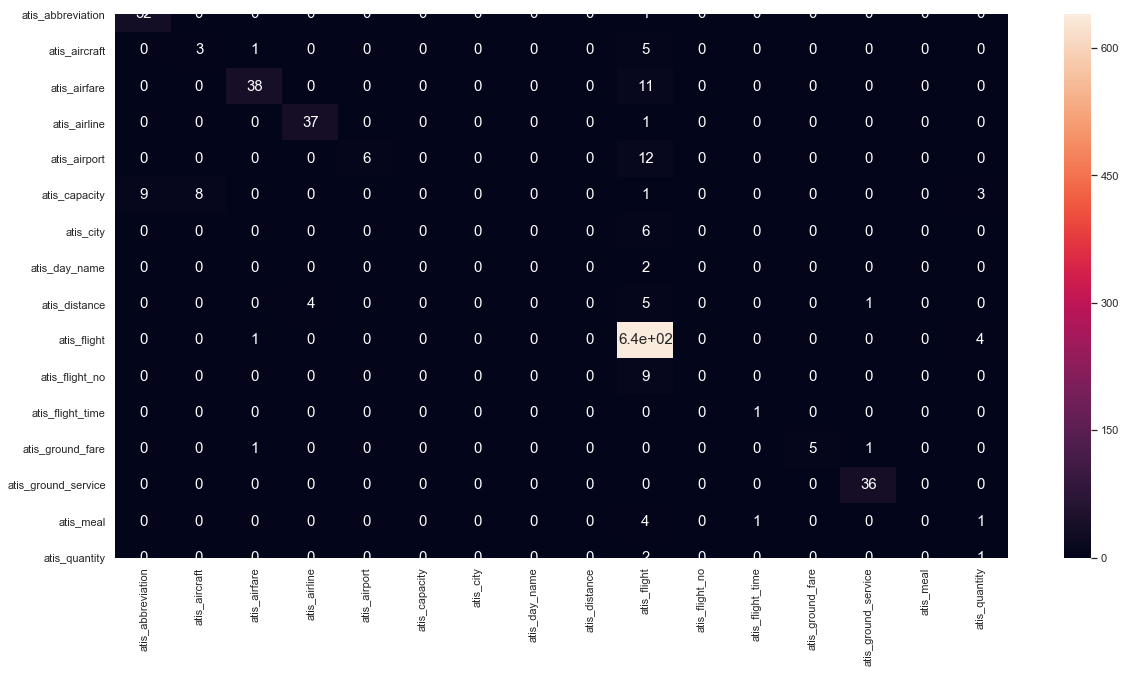

In [42]:
plt.rcParams["figure.figsize"] = [20, 10]
cm = confusion_matrix(y_pred=y_pred, y_true=rounded_labels)
labels = uni_labels_test
dfcm = pd.DataFrame(cm, labels, labels)
sn.set(font_scale=1)
sn.heatmap(dfcm, annot=True, annot_kws={'size' : 15})
plt.savefig("f1.png")